In [20]:
# library for mathematical functions and data preprocessing such as table, etc
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew

# Library for visualizing data
import matplotlib.pyplot as plt
import seaborn as sns

# Library for machine learning functions/algorithms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [21]:
# data itself
url = 'lending_club_loan_two.csv'
# description of each column
url_info = 'lending_club_info.csv'
df_before = pd.read_csv(url)
df_info = pd.read_csv(url_info)
df_before.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [22]:
columns_to_drop = ['emp_title', 'address', 'issue_d', 'title', 'earliest_cr_line', 'initial_list_status', 'grade', 'sub_grade', 'purpose']
df_before = df_before.drop(columns=columns_to_drop)

In [23]:
df_before.isna().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
loan_status                 0
dti                         0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
dtype: int64

In [24]:
# label encoder and fit_transform is a function that changes/remap string into number based on alphabetical order
le = LabelEncoder() 
df_before['term'] = le.fit_transform(df_before['term'])
# 36 months = 0,  60 months = 1

df_before['emp_length'] = le.fit_transform(df_before['emp_length'])
# '1 year' = 0, '10+ years' = 1, '2 years' = 2, '3 years' = 3, '4 years' = 4, '5 years' = 5,   
# '6 years' = 6, '7 years' = 7, '8 years' = 8,  '9 years' = 9, '< 1 year' = 10

df_before['home_ownership'] = le.fit_transform(df_before['home_ownership'])
# 'ANY' = 0, 'MORTGAGE' = 1, 'NONE' = 2, 'OTHER' = 3, 'OWN' = 4, 'RENT' = 5

df_before['verification_status'] = le.fit_transform(df_before['verification_status'])
# 'Not Verified' = 0, 'Source Verified' = 1, 'Verified' = 2

df_before['application_type'] = le.fit_transform(df_before['application_type'])
# 'DIRECT_PAY' = 0, 'INDIVIDUAL' = 1, 'JOINT' = 2


In [25]:
df_before['emp_length'].fillna(df_before['emp_length'].median(), inplace=True)
df_before['pub_rec_bankruptcies'].fillna(df_before['pub_rec_bankruptcies'].median(), inplace=True)
df_before['mort_acc'].fillna(df_before['mort_acc'].median(), inplace=True)
df_before['revol_util'].fillna(df_before['revol_util'].mean(), inplace=True)

In [26]:
z_score_vars = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'total_acc']

no_outlier = df_before.copy()

# Store outlier counts and percentages for each column
outlier_info = {}

for col in z_score_vars:
    # since our dataset is skewed we use the 99 percentile formula to detect and delete outliers, only identifying extreme datas
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)

    # Count outliers before clipping
    outlier_count = ((df_before[col] < lower_limit) | (df_before[col] > upper_limit)).sum()
    total_count = len(df_before[col])
    outlier_percentage = outlier_count / total_count * 100

    # Store outlier information for the column
    outlier_info[col] = {'count': outlier_count, 'percentage': outlier_percentage}

# Print outlier information for each column
print("Outlier information:")
for col, info in outlier_info.items():
    print(f"- {col}: {info['count']} outliers ({info['percentage']:.2f}%)")

# Drop rows with outliers
for col in z_score_vars:
    lower_limit = df_before[col].quantile(0.01)
    upper_limit = df_before[col].quantile(0.99)
    no_outlier = no_outlier[(no_outlier[col] >= lower_limit) & (no_outlier[col] <= upper_limit)]

Outlier information:
- loan_amnt: 4089 outliers (1.03%)
- int_rate: 7823 outliers (1.98%)
- installment: 7916 outliers (2.00%)
- annual_inc: 7237 outliers (1.83%)
- dti: 7905 outliers (2.00%)
- open_acc: 5372 outliers (1.36%)
- revol_bal: 7918 outliers (2.00%)
- total_acc: 7553 outliers (1.91%)


In [27]:
#  SPLIT
target_column = 'loan_status'
feature_columns = no_outlier.columns[no_outlier.columns != target_column]

X = no_outlier[feature_columns]
y = no_outlier[target_column]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Undersample majority class by half
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_rus, y_train_rus)

In [42]:
data_counts = y_train_resampled.value_counts()
print(data_counts)

loan_status
Charged Off    109250
Fully Paid     109250
Name: count, dtype: int64


In [52]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming X_train_resampled and X_test are your input data arrays

# Step 1: Standardize the training data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_resampled)

# Convert standardized training data to a DataFrame
X_train_standardized_df = pd.DataFrame(X_train_standardized, columns=X_train_resampled.columns)

# Step 2: Apply PCA to the standardized training data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_standardized)

# Convert PCA-transformed training data to a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=['Principal Component 1', 'Principal Component 2'])

# Standardize the test data using the same scaler
X_test_standardized = scaler.transform(X_test)

# Convert standardized test data to a DataFrame
X_test_standardized_df = pd.DataFrame(X_test_standardized, columns=X_test.columns)

# Apply PCA to the standardized test data
X_test_pca = pca.transform(X_test_standardized)

# Convert PCA-transformed test data to a DataFrame
X_test_pca_df = pd.DataFrame(X_test_pca, columns=['Principal Component 1', 'Principal Component 2'])


In [56]:
data_counts = X_test_pca_df.value_counts()
print(data_counts)

Principal Component 1  Principal Component 2
-7.901504               0.264437                1
 1.089904              -1.176455                1
 1.090224              -1.621758                1
 1.090216               1.862957                1
 1.090174               1.329211                1
                                               ..
-0.575700              -2.854323                1
-0.575698               2.058046                1
-0.575691              -1.703332                1
-0.575678              -0.218730                1
 4.570584               5.284714                1
Name: count, Length: 70334, dtype: int64


In [31]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

clf = RandomForestClassifier(n_estimators=100, bootstrap=True, criterion='gini', max_depth=None,  random_state=0)

clf.fit(X_pca, y_train_resampled)

y_pred_test = clf.predict(X_test_pca)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {accuracy_test}')


Test Accuracy: 0.6543492478744277


Loadings (Principal Components vs Features):
[[-0.5 -0.2 -0.1 -0.4  0.1  0.2 -0.3 -0.2 -0.1 -0.2  0.1 -0.3 -0.1 -0.3
  -0.  -0.2  0.1]
 [-0.2 -0.3 -0.4 -0.2 -0.1 -0.3  0.2 -0.2 -0.1  0.3  0.2 -0.  -0.3  0.4
  -0.   0.3  0.2]]


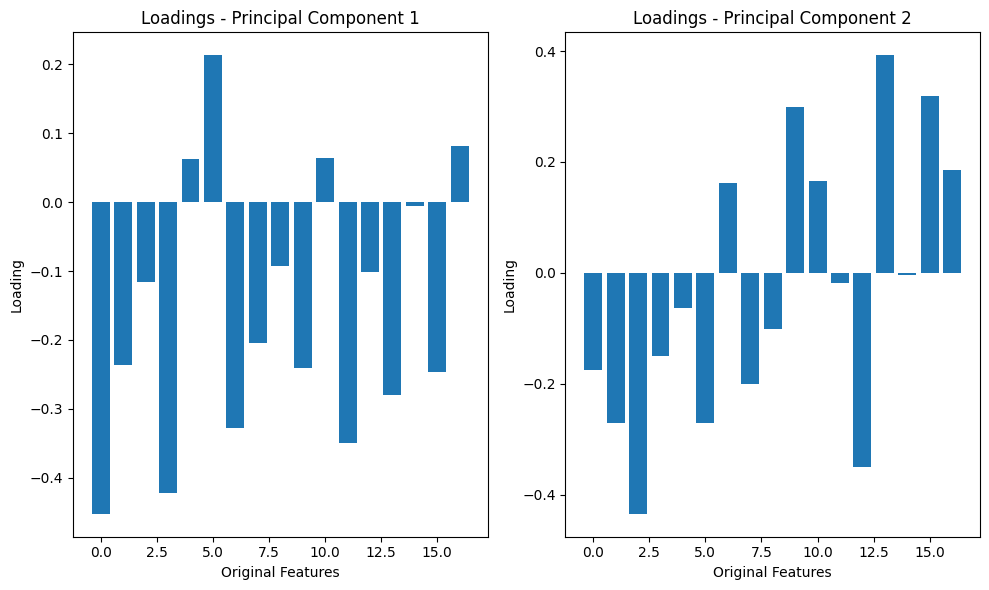

In [55]:
print("Loadings (Principal Components vs Features):")
print(pca.components_)

# Plot the loadings of the first two principal components
n_components_to_plot = 2
plt.figure(figsize=(10, 6))
for i in range(n_components_to_plot):
    plt.subplot(1, n_components_to_plot, i + 1)
    plt.bar(range(len(pca.components_[i])), pca.components_[i])
    plt.title(f'Loadings - Principal Component {i + 1}')
    plt.xlabel('Original Features')
    plt.ylabel('Loading')
plt.tight_layout()
plt.show()

In [36]:
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix\n", cm)

Confusion Matrix
 [[ 5154  8521]
 [15790 40869]]


In [38]:
target_names = ['Charged Off', 'Fully Paid']
print(classification_report(y_test, y_pred_test, target_names=target_names))

              precision    recall  f1-score   support

 Charged Off       0.25      0.38      0.30     13675
  Fully Paid       0.83      0.72      0.77     56659

    accuracy                           0.65     70334
   macro avg       0.54      0.55      0.53     70334
weighted avg       0.71      0.65      0.68     70334



In [34]:
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# pos_label = 'Charged Off'
pos_label = 'Fully Paid'
precision = precision_score(y_test, y_pred_test, pos_label=pos_label)
print("Precision:", precision)

recall = recall_score(y_test, y_pred_test, pos_label=pos_label)
print("Recall:", recall)

specificity = TN / (TN + FP)
print("Specificity:", specificity)

f1 = f1_score(y_test, y_pred_test, pos_label=pos_label)
print("F1 Score:", f1)

Accuracy: 0.6543492478744277
Precision: 0.8274751974083823
Recall: 0.7213152367673273
Specificity: 0.37689213893967094
F1 Score: 0.7707569142566172


In [35]:
# Assuming you have the predicted probabilities for the positive class
y_prob_test = clf.predict_proba(X_test)[:, 1]

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob_test)
print("AUC Score:", auc_score)

c:\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 17 features, but RandomForestClassifier is expecting 2 features as input.